In [71]:
import pandas as pd
import boto3
import re

df = pd.read_json('applicant_data_SM.json')

df = df.dropna(subset=['program'])

df['program'] = df['program'].str.strip() + ', ' + df['school_name'].str.strip()

# Drop the old 'school_name' column
df = df.drop(columns=['school_name'])

df.head(5)

,program,degree,date_added,decision,result_url,semester_year,international_american,gpa,comment,gre_score,gre_v_score,gre_aw
0,"Electrical Engineering, Stanford University",Masters,"May 29, 2025",Accepted on 29 May,https://www.thegradcafe.com/result/986059,Fall 2025,American,GPA 3.79,Part-time Masters (HCP). 4 non-first-author pu...,NaN,NaN,NaN
1,"Biomedical Engineering, Columbia University",PhD,"May 29, 2025",Rejected on 29 May,https://www.thegradcafe.com/result/986058,Fall 2025,American,GPA 3.53,Grad GPA: 3:63,NaN,NaN,NaN
2,"Electrical Engineering, Stanford University",Masters,"May 29, 2025",Rejected on 29 May,https://www.thegradcafe.com/result/986057,Fall 2025,International,GPA 3.85,Part-time Masters (HCP). 1 publication not as ...,NaN,NaN,NaN
3,"Mechanical Engineering, Purdue University",PhD,"May 29, 2025",Rejected on 28 May,https://www.thegradcafe.com/result/986056,Fall 2025,International,GPA 3.8,NaN,NaN,NaN,NaN
4,"Kinesiology, University of Toronto",Masters,"May 29, 2025",Wait listed on 5 Feb,https://www.thegradcafe.com/result/986055,Fall 2025,International,NaN,Ignore Status Has anyone heard back for Master...,NaN,NaN,NaN


In [72]:
# Split combined 'program' column into two parts
parts = df['program'].str.split(',', n=1, expand=True)

# Assign second part as university, first part as program (strip whitespace)
df['program'] = parts[0].str.strip()
df['university'] = parts[1].str.strip()

df.head(5)


,program,degree,date_added,decision,result_url,semester_year,international_american,gpa,comment,gre_score,gre_v_score,gre_aw,university
0,Electrical Engineering,Masters,"May 29, 2025",Accepted on 29 May,https://www.thegradcafe.com/result/986059,Fall 2025,American,GPA 3.79,Part-time Masters (HCP). 4 non-first-author pu...,NaN,NaN,NaN,Stanford University
1,Biomedical Engineering,PhD,"May 29, 2025",Rejected on 29 May,https://www.thegradcafe.com/result/986058,Fall 2025,American,GPA 3.53,Grad GPA: 3:63,NaN,NaN,NaN,Columbia University
2,Electrical Engineering,Masters,"May 29, 2025",Rejected on 29 May,https://www.thegradcafe.com/result/986057,Fall 2025,International,GPA 3.85,Part-time Masters (HCP). 1 publication not as ...,NaN,NaN,NaN,Stanford University
3,Mechanical Engineering,PhD,"May 29, 2025",Rejected on 28 May,https://www.thegradcafe.com/result/986056,Fall 2025,International,GPA 3.8,NaN,NaN,NaN,NaN,Purdue University
4,Kinesiology,Masters,"May 29, 2025",Wait listed on 5 Feb,https://www.thegradcafe.com/result/986055,Fall 2025,International,NaN,Ignore Status Has anyone heard back for Master...,NaN,NaN,NaN,University of Toronto


In [73]:
# Count occurrences of each program_name
program_counts = df['program'].value_counts()

# Filter to get programs with fewer than 3 occurrences
rare_programs = program_counts[program_counts < 3]

print(rare_programs)

program
EIPER                            2
Nanoscale Engineering            2
ORFE                             2
Ancient History                  2
Gender                           2
                                ..
Environmental Economics          1
development en                   1
AI Center Doctoral Fellowship    1
Optical Science                  1
Mechatronics and Robotics        1
Name: count, Length: 1276, dtype: int64


In [74]:
def extract_outcome(status):
    outcomes = ["Waitlisted", "Interviewed", "Rejected", "Accepted"]
    for outcome in outcomes:
        if outcome in status:
            return outcome
    return None

def extract_decision_date(status, semester_year):
    match = re.search(r'on (\d{1,2} \w{3})', status)
    if match:
        date_str = match.group(1)
        year_match = re.search(r'\b(\d{4})\b', semester_year)
        year = year_match.group(1) if year_match else '2025'  # default year if missing
        full_date_str = f"{date_str} {year}"
        try:
            return pd.to_datetime(full_date_str, format='%d %b %Y')
        except:
            return pd.NaT
    else:
        return pd.NaT

df['outcome'] = df['decision'].apply(extract_outcome)
df['decision_date'] = df.apply(lambda row: extract_decision_date(row['decision'], row['semester_year']), axis=1)

# Drop original decision column
df = df.drop(columns=['decision'])

# Keep only rows where outcome is one of the valid options
valid_outcomes = ["Waitlisted", "Interviewed", "Rejected", "Accepted"]
df = df[df['outcome'].isin(valid_outcomes)]

df.head(5)

,program,degree,date_added,result_url,semester_year,international_american,gpa,comment,gre_score,gre_v_score,gre_aw,university,outcome,decision_date
0,Electrical Engineering,Masters,"May 29, 2025",https://www.thegradcafe.com/result/986059,Fall 2025,American,GPA 3.79,Part-time Masters (HCP). 4 non-first-author pu...,NaN,NaN,NaN,Stanford University,Accepted,2025-05-29
1,Biomedical Engineering,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986058,Fall 2025,American,GPA 3.53,Grad GPA: 3:63,NaN,NaN,NaN,Columbia University,Rejected,2025-05-29
2,Electrical Engineering,Masters,"May 29, 2025",https://www.thegradcafe.com/result/986057,Fall 2025,International,GPA 3.85,Part-time Masters (HCP). 1 publication not as ...,NaN,NaN,NaN,Stanford University,Rejected,2025-05-29
3,Mechanical Engineering,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986056,Fall 2025,International,GPA 3.8,NaN,NaN,NaN,NaN,Purdue University,Rejected,2025-05-28
5,Chemistry,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986054,Fall 2025,International,GPA 3.39,NaN,NaN,NaN,NaN,Colorado State University,Rejected,2025-05-27


In [75]:
# Define allowed values
allowed_degrees = ["Masters", "PhD", "PsyD"]
allowed_us_intl = ["International", "American", "Other"]

# Filter rows where 'degree' is in allowed_degrees
df = df[df['degree'].isin(allowed_degrees)]

# Filter rows where 'international_american' is in allowed_us_intl
df = df[df['international_american'].isin(allowed_us_intl)]

df.head(5)


,program,degree,date_added,result_url,semester_year,international_american,gpa,comment,gre_score,gre_v_score,gre_aw,university,outcome,decision_date
0,Electrical Engineering,Masters,"May 29, 2025",https://www.thegradcafe.com/result/986059,Fall 2025,American,GPA 3.79,Part-time Masters (HCP). 4 non-first-author pu...,NaN,NaN,NaN,Stanford University,Accepted,2025-05-29
1,Biomedical Engineering,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986058,Fall 2025,American,GPA 3.53,Grad GPA: 3:63,NaN,NaN,NaN,Columbia University,Rejected,2025-05-29
2,Electrical Engineering,Masters,"May 29, 2025",https://www.thegradcafe.com/result/986057,Fall 2025,International,GPA 3.85,Part-time Masters (HCP). 1 publication not as ...,NaN,NaN,NaN,Stanford University,Rejected,2025-05-29
3,Mechanical Engineering,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986056,Fall 2025,International,GPA 3.8,NaN,NaN,NaN,NaN,Purdue University,Rejected,2025-05-28
5,Chemistry,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986054,Fall 2025,International,GPA 3.39,NaN,NaN,NaN,NaN,Colorado State University,Rejected,2025-05-27


In [76]:
def clean_score(value, prefix):
    if pd.isna(value):
        return None
    value = str(value).lower()
    value = value.replace(prefix.lower(), '').strip()
    try:
        return float(value)
    except ValueError:
        return None

df['gpa'] = df['gpa'].apply(lambda x: clean_score(x, 'gpa'))
df['gre_score'] = df['gre_score'].apply(lambda x: clean_score(x, 'gre'))
df['gre_v_score'] = df['gre_v_score'].apply(lambda x: clean_score(x, 'gre v'))
df['gre_aw'] = df['gre_aw'].apply(lambda x: clean_score(x, 'gre aw'))

df.head(5)

,program,degree,date_added,result_url,semester_year,international_american,gpa,comment,gre_score,gre_v_score,gre_aw,university,outcome,decision_date
0,Electrical Engineering,Masters,"May 29, 2025",https://www.thegradcafe.com/result/986059,Fall 2025,American,3.79,Part-time Masters (HCP). 4 non-first-author pu...,NaN,NaN,NaN,Stanford University,Accepted,2025-05-29
1,Biomedical Engineering,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986058,Fall 2025,American,3.53,Grad GPA: 3:63,NaN,NaN,NaN,Columbia University,Rejected,2025-05-29
2,Electrical Engineering,Masters,"May 29, 2025",https://www.thegradcafe.com/result/986057,Fall 2025,International,3.85,Part-time Masters (HCP). 1 publication not as ...,NaN,NaN,NaN,Stanford University,Rejected,2025-05-29
3,Mechanical Engineering,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986056,Fall 2025,International,3.80,NaN,NaN,NaN,NaN,Purdue University,Rejected,2025-05-28
5,Chemistry,PhD,"May 29, 2025",https://www.thegradcafe.com/result/986054,Fall 2025,International,3.39,NaN,NaN,NaN,NaN,Colorado State University,Rejected,2025-05-27


In [77]:
# Save the cleaned DataFrame to a JSON file
cleaned_filename = 'cleaned_applicant_data.json'
df.to_json(cleaned_filename, orient='records', lines=False)

# S3 bucket and key (update if needed)
BUCKET_NAME = 'grad-cafe-spg'
CLEANED_KEY = 'cleaned_applicant_data.json'

# Create S3 client
s3 = boto3.client('s3')

# Upload the file
s3.upload_file(cleaned_filename, BUCKET_NAME, CLEANED_KEY)

print(f"Uploaded cleaned file to s3://{BUCKET_NAME}/{CLEANED_KEY}")

Uploaded cleaned file to s3://grad-cafe-spg/cleaned_applicant_data.json


Matplotlib is building the font cache; this may take a moment.


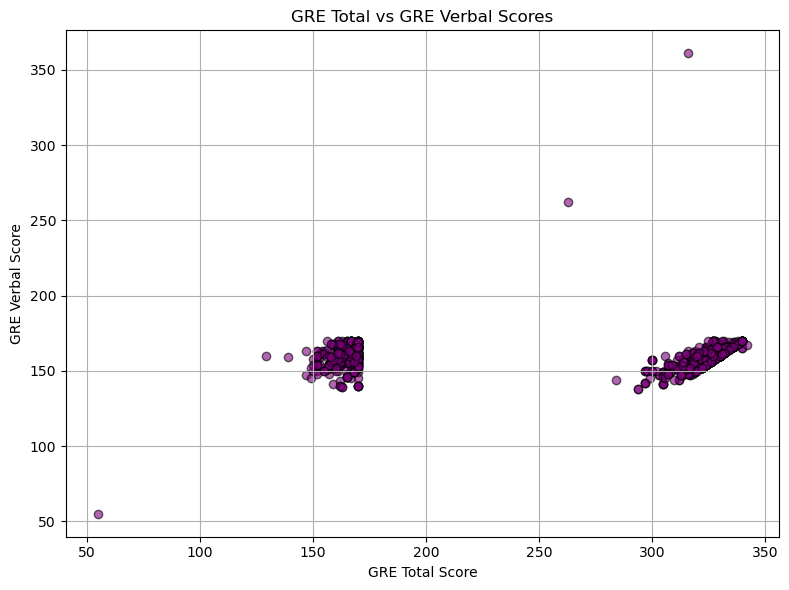

In [78]:
import matplotlib.pyplot as plt

# Filter out zero or missing GRE scores
scatter_df = df[(df['gre_score'] > 0) & (df['gre_v_score'] > 0)]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(scatter_df['gre_score'], scatter_df['gre_v_score'], alpha=0.6, color='purple', edgecolors='black')

plt.title('GRE Total vs GRE Verbal Scores')
plt.xlabel('GRE Total Score')
plt.ylabel('GRE Verbal Score')
plt.grid(True)
plt.tight_layout()
plt.show()


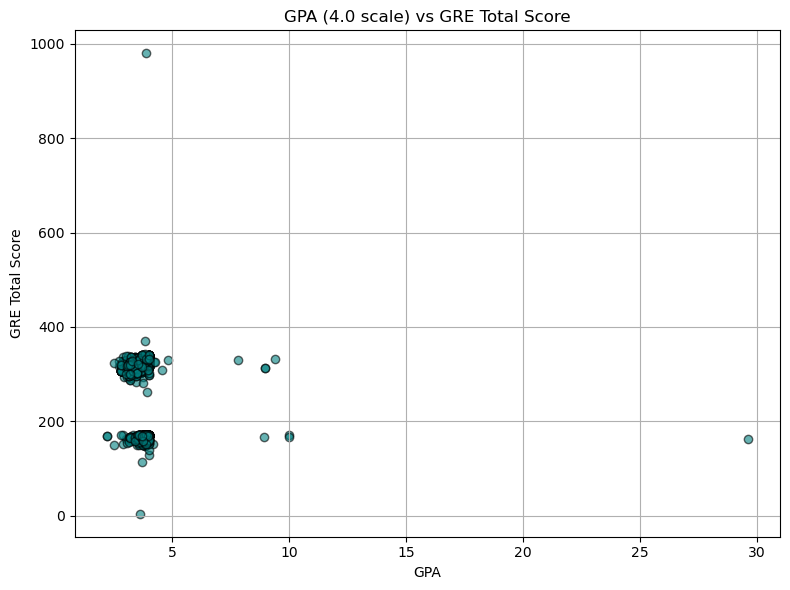

In [79]:
# Filter rows where both GPA and GRE scores are non-zero and not null
scatter_df = df[(df['gpa'] > 0) & (df['gre_score'] > 0)]

plt.figure(figsize=(8, 6))
plt.scatter(scatter_df['gpa'], scatter_df['gre_score'], alpha=0.6, color='teal', edgecolors='black')

plt.title('GPA (4.0 scale) vs GRE Total Score')
plt.xlabel('GPA')
plt.ylabel('GRE Total Score')
plt.grid(True)
plt.tight_layout()
plt.show()

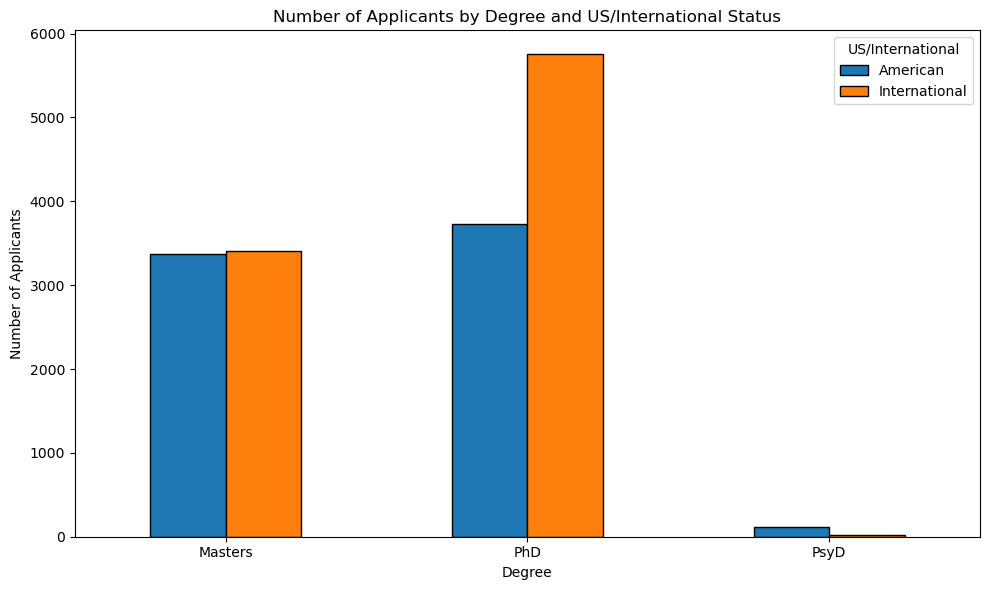

In [80]:
# Group by 'degree' and 'international_american' and count applicants
grouped = df.groupby(['degree', 'international_american']).size().unstack(fill_value=0)

# Plot grouped bar chart
grouped.plot(kind='bar', figsize=(10,6), edgecolor='black')

plt.title('Number of Applicants by Degree and US/International Status')
plt.xlabel('Degree')
plt.ylabel('Number of Applicants')
plt.xticks(rotation=0)
plt.legend(title='US/International')
plt.tight_layout()
plt.show()

/tmp/ipykernel_12733/2838436270.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted_df['decision_date'] = pd.to_datetime(accepted_df['decision_date'])


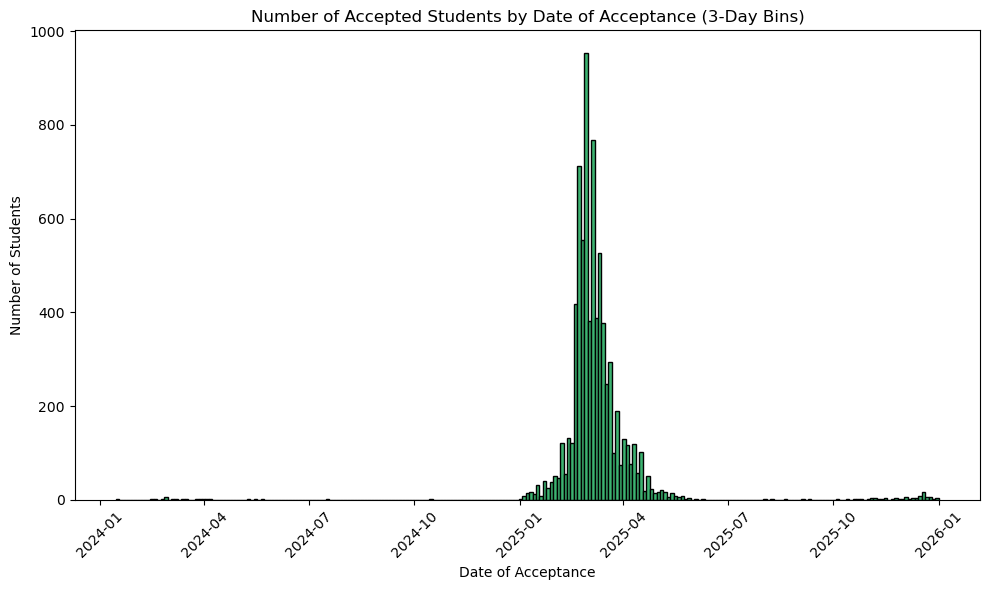

In [81]:
# Filter for accepted students with valid decision_date
accepted_df = df[(df['outcome'] == 'Accepted') & (df['decision_date'].notna())]

# Make sure decision_date is a datetime (just in case)
accepted_df['decision_date'] = pd.to_datetime(accepted_df['decision_date'])

plt.figure(figsize=(10,6))

# Plot histogram with 3-day bins
plt.hist(accepted_df['decision_date'], bins=pd.date_range(
    start=accepted_df['decision_date'].min(),
    end=accepted_df['decision_date'].max() + pd.Timedelta(days=3),
    freq='3D'
), color='mediumseagreen', edgecolor='black')

plt.title('Number of Accepted Students by Date of Acceptance (3-Day Bins)')
plt.xlabel('Date of Acceptance')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()